In [3]:
!chmod -R 777 /content/drive/MyDrive/UBA/MetNum/TP2MetNum
!apt-get install libeigen3-dev
!add-apt-repository ppa:ubuntu-toolchain-r/test
!apt-get update
!apt-get install gcc-4.9
!apt-get install --only-upgrade libstdc++6

^C
PPA publishes dbgsym, you may need to include 'main/debug' component
Repository: 'deb https://ppa.launchpadcontent.net/ubuntu-toolchain-r/test/ubuntu/ jammy main'
Description:
Toolchain test builds; see https://wiki.ubuntu.com/ToolChain

More info: https://launchpad.net/~ubuntu-toolchain-r/+archive/ubuntu/test
Adding repository.
Press [ENTER] to continue or Ctrl-c to cancel.
Found existing deb entry in /etc/apt/sources.list.d/ubuntu-toolchain-r-ubuntu-test-jammy.list
Adding deb entry to /etc/apt/sources.list.d/ubuntu-toolchain-r-ubuntu-test-jammy.list
Found existing deb-src entry in /etc/apt/sources.list.d/ubuntu-toolchain-r-ubuntu-test-jammy.list
Adding disabled deb-src entry to /etc/apt/sources.list.d/ubuntu-toolchain-r-ubuntu-test-jammy.list
Adding key to /etc/apt/trusted.gpg.d/ubuntu-toolchain-r-ubuntu-test.gpg with fingerprint 60C317803A41BA51845E371A1E9377A2BA9EF27F
Hit:1 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:2 https://cloud.r-project.org/bin/linux/ubu

In [4]:
repreprocess = False # Volver a preprocesar los datos de facebook
recompute = False    # Volver a calcular autovalores y autovectores costosos (karate, facebook)

# Imports y funciones

In [5]:
import os
import sys
import numpy as np
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import subprocess

sns.set_theme()
os.chdir("/content/drive/MyDrive/UBA/MetNum/TP2MetNum")

def write_matrix_to_file(A: np.array, filename: str = "input_data.txt") -> None:
    with open(filename,"w") as f:
        f.write(f"{A.shape[0]} {A.shape[1]}\n")
        np.savetxt(f,A, newline="\n")


def read_matrix_from_file(filename: str = "output_data.txt") -> None:
    return np.loadtxt(filename)


def compile_cpp(filename: str) -> None:
    subprocess.run([
        "g++",
        filename,
        "-O3",
        "-o",
        "out"
    ])


def eig(A: np.array, num: int = 1, niter: int = 10_000, eps: float = 1e-6) -> tuple[np.array, np.array]:
    write_matrix_to_file(A, "input_data.txt")
    subprocess.run([
        "./out",
        "input_data.txt",
        "output_eigenvectors.txt",
        "output_eigenvalues.txt",
        str(num),
        str(niter),
        "{:f}".format(eps)
    ])
    V = read_matrix_from_file("output_eigenvectors.txt")
    l = read_matrix_from_file("output_eigenvalues.txt")
    return sorted_eigen(l, V)


def sorted_eigen(l: np.array, V: np.array, rev: bool = True, absolute = False) -> tuple[np.array, np.array]:
    sort_key = (lambda x: x[0]) if absolute == False else (lambda x: abs(x[0]))
    paired_lv = sorted([(l[i], V[:,i]) for i in range(len(l))], key = sort_key, reverse = rev)
    sorted_l = np.array([pair[0] for pair in paired_lv])
    sorted_V = np.column_stack([pair[1] for pair in paired_lv])
    return sorted_l, sorted_V


def laplacian_matrix(A: np.array) -> np.array:
    D = np.diag(np.sum(A, axis = 1))
    return D - A


def plot_eigenvalues(l: np.array) -> None:
    plt.plot(l, 'o')
    plt.show()


def feature_threshold_adyacency_matrix(C: np.array, u: int) -> np.array:
    A_C = (C >= u).astype(int)
    np.fill_diagonal(A_C, 0)
    return A_C


def normalize_V(V: np.array) -> np.array:
    norms = np.linalg.norm(V, axis = 0)
    return V/norms

# Preprocesamiento de datos de Facebook

In [ ]:
if repreprocess:
    X = read_matrix_from_file("redes/ego-facebook.feat")
    edges = read_matrix_from_file("redes/ego-facebook.edges")
    np.savetxt("redes/ego-facebook-pre.feat", X[:, 1:], fmt = '%i', newline = "\n")
    dict_replace = dict(zip(X[:, 0], range(X.shape[0])))
    norm_edges = np.vectorize(lambda e: dict_replace.get(e, e))(edges)
    np.savetxt("redes/ego-facebook-pre.edges", norm_edges, fmt = '%i', newline = "\n")
    A_facebook = np.zeros((X.shape[0], X.shape[0]))
    for pair in norm_edges:
        A_facebook[pair[0], pair[1]] = 1
        A_facebook[pair[1], pair[0]] = 1
    np.savetxt("redes/facebook_matriz.txt", A_facebook, fmt = '%i', newline = "\n")

# 1.2. Casos de prueba y análisis de convergencia

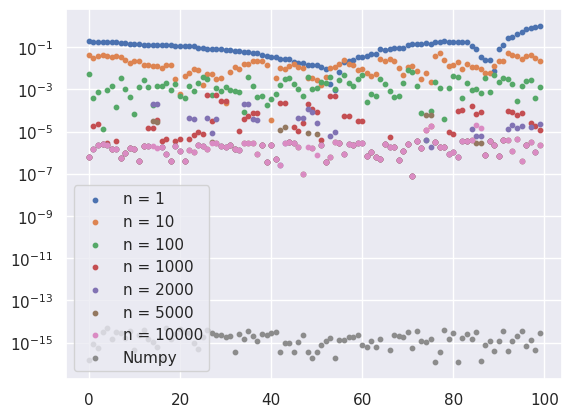

In [ ]:
# Convergencia de autovalores
res = []
niters = [1, 10, 100, 1000, 2000, 5000, 10000]

evals = sorted(np.random.rand(100)*100+100, reverse = True)
D = np.diag(evals)
v = np.ones((D.shape[0], 1))
v = v / np.linalg.norm(v)
B = np.eye(D.shape[0]) - 2 * (v @ v.T)
M = B @ D @ B.T

l_np, V_np = sorted_eigen(*np.linalg.eig(M))
errors_np = abs((l_np-evals)/evals)
for nit in niters:
    l, V = eig(M, M.shape[0], niter = nit, eps = 0)
    res.append(abs((l-evals)/evals))

for errors in res:
    plt.scatter(range(100), errors, s = 10)
plt.scatter(range(100), errors_np, s = 10)
plt.legend([f"n = {nit}" for nit in niters] + ["Numpy"])
plt.yscale("log")
plt.show()

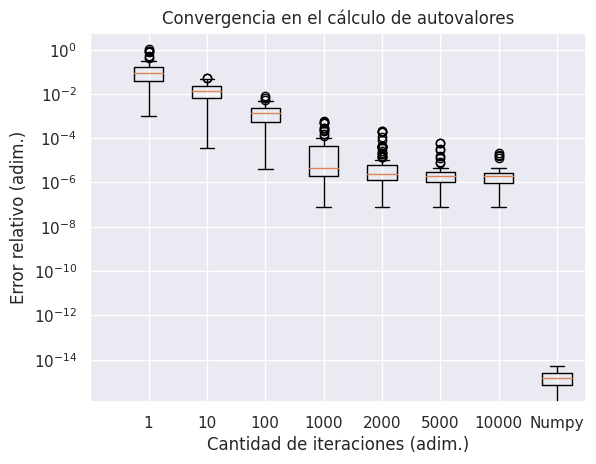

In [ ]:
# Convergencia de autovalores (boxplot)

plt.boxplot(res + [errors_np])
plt.yscale("log")
plt.xlabel("Cantidad de iteraciones (adim.)")
plt.ylabel("Error relativo (adim.)")
plt.title("Convergencia en el cálculo de autovalores")
plt.xticks(ticks = range(len(niters) + 2), labels = [" "] + niters + ["Numpy"])
plt.savefig("img/convergencia_autovalores.svg", bbox_inches = "tight")
plt.show()

In [ ]:
# Convergencia con autovalores repetidos
n = 100
reps = [1, 2, 3, 4, 5]
res = [[0]*n for _ in range(len(reps))]
evals = list(sorted(np.random.rand(10), reverse = True))
for i, rep in enumerate(reps):
    rep_evals = [evals[0]]*rep + evals[rep:]
    D = np.diag(rep_evals)
    v = np.ones((D.shape[0], 1))
    v = v / np.linalg.norm(v)
    B = np.eye(D.shape[0]) - 2 * (v @ v.T)
    M = B @ D @ B.T
    for j in range(n):
        l, V = eig(M, M.shape[0], niter = 100000, eps = 0)
        res[i][j] = np.mean([np.sum((M@V[:,k] - l[k]*V[:,k])**2)/10 for k in range(len(evals))])

In [27]:
# Autovalores parecidos
n_reps = 100
niters = [5, 10, 20, 30, 40, 50, 100]
ECM_random, ECM_close = [[] for _ in range(len(niters))], [[] for _ in range(len(niters))]
for _ in range(n_reps):
    evals = list(sorted(np.random.rand(10)*100, reverse = True))
    evals_close = [evals[0]] + [evals[0] - 10**(-10)] + evals[2:]
    D = np.diag(evals)
    D_close = np.diag(evals_close)
    v = np.ones((D.shape[0], 1))
    v = v / np.linalg.norm(v)
    B = np.eye(D.shape[0]) - 2 * np.outer(v, v)
    M = B @ D @ B.T
    M_close = B @ D_close @ B.T
    for i, nit in enumerate(niters):
        l, V = eig(M, M.shape[0], niter = nit, eps = 0)
        l_close, V_close = eig(M_close, M.shape[0], niter = nit, eps = 0)
        ECM_random[i].append(np.sum((M@V[:,0] - l[0]*V[:,0])**2)/10)
        ECM_close[i].append(np.sum((M_close@V_close[:,0] - l_close[0]*V_close[:,0])**2)/10)

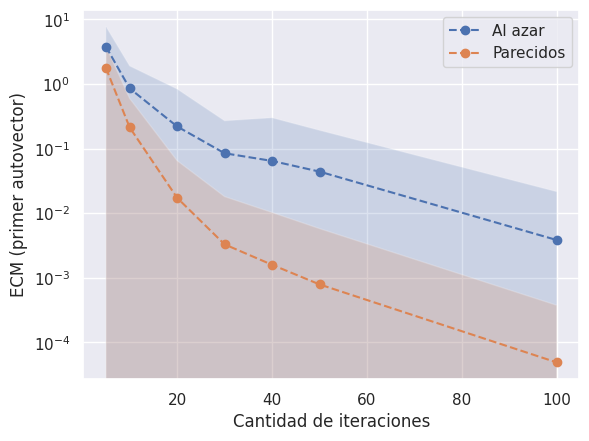

In [34]:
medias_ECM_random = [np.mean(sublist) for sublist in ECM_random]
desvios_ECM_random = [np.std(sublist) for sublist in ECM_random]
medias_ECM_close = [np.mean(sublist) for sublist in ECM_close]
desvios_ECM_close = [np.std(sublist) for sublist in ECM_close]

plt.plot(niters, medias_ECM_random, "--o")
plt.plot(niters, medias_ECM_close, "--o")
plt.fill_between(niters, np.array(medias_ECM_random) + np.array(desvios_ECM_random), np.array(medias_ECM_random) - np.array(desvios_ECM_random), alpha = 0.2)
plt.fill_between(niters, np.array(medias_ECM_close) + np.array(desvios_ECM_close), np.array(medias_ECM_close) - np.array(desvios_ECM_close), alpha = 0.2)
plt.yscale("log")
plt.xlabel("Cantidad de iteraciones")
plt.ylabel("ECM (primer autovector)")
plt.legend(["Al azar", "Parecidos"])
plt.savefig("img/convergencia_parecidos.svg", bbox_inches = "tight")
plt.show()

In [31]:
# Autovalores repetidos (2)
n_reps = 100
niters = [5, 10, 20, 30, 40, 50, 100]
ECM_random_same, ECM_same = [[] for _ in range(len(niters))], [[] for _ in range(len(niters))]
for _ in range(n_reps):
    evals = list(sorted(np.random.rand(10)*100, reverse = True))
    evals_same = [evals[0]]*2 + evals[2:]
    D = np.diag(evals)
    D_same = np.diag(evals_same)
    v = np.random.rand(10)+1
    v = v / np.linalg.norm(v)
    B = np.eye(D.shape[0]) - 2 * np.outer(v, v)
    M = B @ D @ B.T
    M_same = B @ D_same @ B.T
    for i, nit in enumerate(niters):
        l, V = eig(M, M.shape[0], niter = nit, eps = 0)
        l_same, V_same = eig(M_same, M.shape[0], niter = nit, eps = 0)
        ECM_random_same[i].append(np.sum((M@V[:,0] - l[0]*V[:,0])**2)/10)
        ECM_same[i].append(np.sum((M_same@V_same[:,0] - l_same[0]*V_same[:,0])**2)/10)

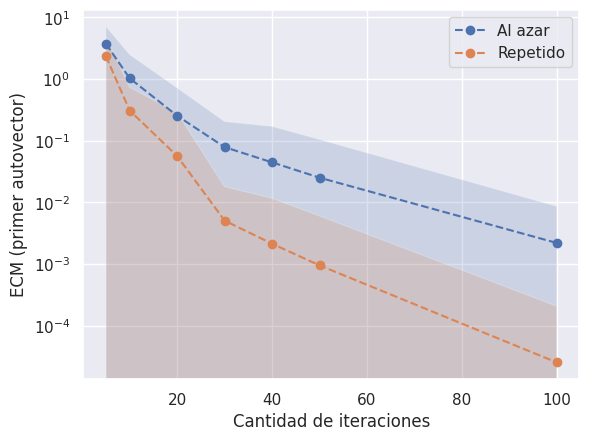

In [35]:
medias_ECM_random_same = [np.mean(sublist) for sublist in ECM_random_same]
desvios_ECM_random_same = [np.std(sublist) for sublist in ECM_random_same]
medias_ECM_same = [np.mean(sublist) for sublist in ECM_same]
desvios_ECM_same = [np.std(sublist) for sublist in ECM_same]

plt.plot(niters, medias_ECM_random_same, "--o")
plt.plot(niters, medias_ECM_same, "--o")
plt.fill_between(niters, np.array(medias_ECM_random_same) + np.array(desvios_ECM_random_same), np.array(medias_ECM_random_same) - np.array(desvios_ECM_random_same), alpha = 0.2)
plt.fill_between(niters, np.array(medias_ECM_same) + np.array(desvios_ECM_same), np.array(medias_ECM_same) - np.array(desvios_ECM_same), alpha = 0.2)
plt.yscale("log")
plt.xlabel("Cantidad de iteraciones")
plt.ylabel("ECM (primer autovector)")
plt.legend(["Al azar", "Repetido"])
plt.savefig("img/convergencia_repetidos.svg", bbox_inches = "tight")
plt.show()

# 2.1. Centralidad en la red de Karate

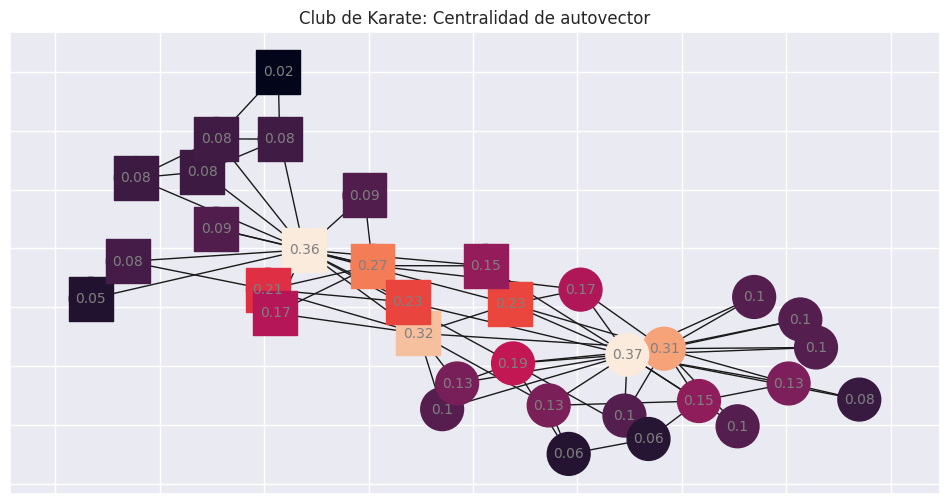

In [ ]:
A_karate = read_matrix_from_file("redes/karateclub_matriz.txt")
n_karate = A_karate.shape[0]
with open("redes/karateclub_labels.txt", "r") as file:
    labels_karate = file.read().split("\n")
    labels_karate = np.array([int(label) for label in labels_karate if label != ""])

if recompute:
    l_A_karate, V_A_karate = eig(A_karate, n_karate, niter = 10_000, eps = 1e-50)
    np.save("nparrays/eval_karate_A.npy", l_A_karate)
    np.save("nparrays/evec_karate_A.npy", V_A_karate)

l_A_karate = np.load("nparrays/eval_karate_A.npy")
V_A_karate = np.load("nparrays/evec_karate_A.npy")
l_A_karate_np, V_A_karate_np = sorted_eigen(*np.linalg.eig(A_karate))
assert(np.allclose(l_A_karate, l_A_karate_np.real))
assert(np.allclose(A_karate@V_A_karate_np, l_A_karate_np*V_A_karate_np))

v_central_A_karate = V_A_karate[:, 0]
v_central_A_karate_norm = v_central_A_karate/np.linalg.norm(v_central_A_karate)
G = nx.from_numpy_array(A_karate)
pos = nx.spring_layout(G, k = 0.35)
# labels_map = {list(G)[i]: f"{labels_karate[i]}\n{round(v_central_A_karate_norm[i], 2)}" for i in range(len(list(G)))}
labels_map = {list(G)[i]: str(round(v_central_A_karate_norm[i], 2)) for i in range(len(list(G)))}
plt.figure(figsize = (12, 6))
nx.draw_networkx(G, pos, node_color = v_central_A_karate_norm, with_labels = False, node_size = 950)
# nx.draw_networkx_nodes(G, pos, node_size = 1000, node_shape = "o", node_color = [v_central_A_karate_norm[i] for i in range(n_karate) if labels_karate[i] == 1], nodelist = [list(G)[i] for i in range(n_karate) if labels_karate[i] == 1])
nx.draw_networkx_nodes(G, pos, node_size = 1000, node_shape = "s", node_color = [v_central_A_karate_norm[i] for i in range(n_karate) if labels_karate[i] == 0], nodelist = [list(G)[i] for i in range(n_karate) if labels_karate[i] == 0])
nx.draw_networkx_labels(G, pos, labels = labels_map, font_color = "grey", font_size = 10)
plt.title("Club de Karate: Centralidad de autovector")
plt.savefig("img/centralidad_karate.svg", bbox_inches = "tight")
plt.show()

# 2.2. Búsqueda del autovector más correlacionado con separación en grupos

In [ ]:
L_karate = laplacian_matrix(A_karate)

if recompute:
    l_L_karate, V_L_karate = eig(L_karate, n_karate, niter = 10_000, eps = 1e-50)
    np.save("nparrays/eval_karate_L.npy", l_L_karate)
    np.save("nparrays/evec_karate_L.npy", V_L_karate)

l_L_karate = np.load("nparrays/eval_karate_L.npy")
V_L_karate = np.load("nparrays/evec_karate_L.npy")
l_L_karate_np, V_L_karate_np = np.linalg.eig(L_karate)
assert(np.allclose(l_L_karate, sorted(l_L_karate_np.real, reverse = True)))
assert(np.allclose(L_karate@V_L_karate_np, l_L_karate_np*V_L_karate_np))

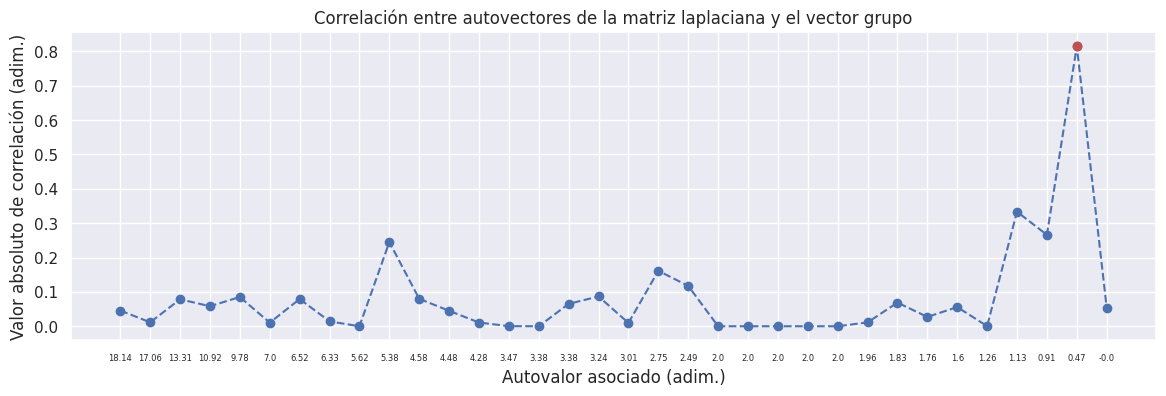

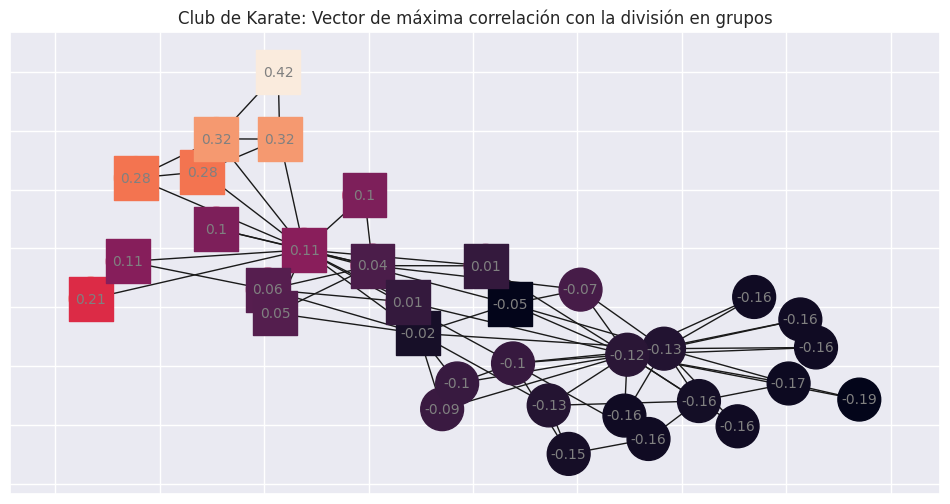

In [ ]:
abs_correlations = np.array([abs(pearsonr(V_L_karate[:, i], labels_karate)[0]) for i in range(n_karate)])
max_correlation_index = abs_correlations.argmax()
v_division_L_karate = V_L_karate[:, max_correlation_index]
plt.figure(figsize = (14, 4))
plt.plot(abs_correlations, "o--")
plt.plot(max_correlation_index, abs_correlations[max_correlation_index], "ro")
plt.xticks(ticks = range(0, n_karate), labels = [round(l, 2) for l in l_L_karate], fontsize = 6)
plt.title("Correlación entre autovectores de la matriz laplaciana y el vector grupo")
plt.xlabel("Autovalor asociado (adim.)")
plt.ylabel("Valor absoluto de correlación (adim.)")
plt.savefig("img/correlacion_karate.svg", bbox_inches = "tight")
plt.show()

# labels_map = {list(G)[i]: f"{labels_karate[i]}\n{round(v_division_L_karate[i], 2)}" for i in range(len(list(G)))}
labels_map = {list(G)[i]: str(round(v_division_L_karate[i], 2)) for i in range(len(list(G)))}
plt.figure(figsize = (12, 6))
nx.draw_networkx(G, pos, node_color = v_division_L_karate, with_labels = False, node_size = 950)
# nx.draw_networkx_nodes(G, pos, node_size = 1000, node_shape = "o", node_color = [v_division_L_karate[i] for i in range(n_karate) if labels_karate[i] == 1], nodelist = [list(G)[i] for i in range(n_karate) if labels_karate[i] == 1])
nx.draw_networkx_nodes(G, pos, node_size = 1000, node_shape = "s", node_color = [v_division_L_karate[i] for i in range(n_karate) if labels_karate[i] == 0], nodelist = [list(G)[i] for i in range(n_karate) if labels_karate[i] == 0])
nx.draw_networkx_labels(G, pos, labels = labels_map, font_color = "grey", font_size = 10)
plt.title("Club de Karate: Vector de máxima correlación con la división en grupos")
plt.savefig("img/division_karate.svg", bbox_inches = "tight")
plt.show()

# 2.2. Comparación de autovectores con numpy

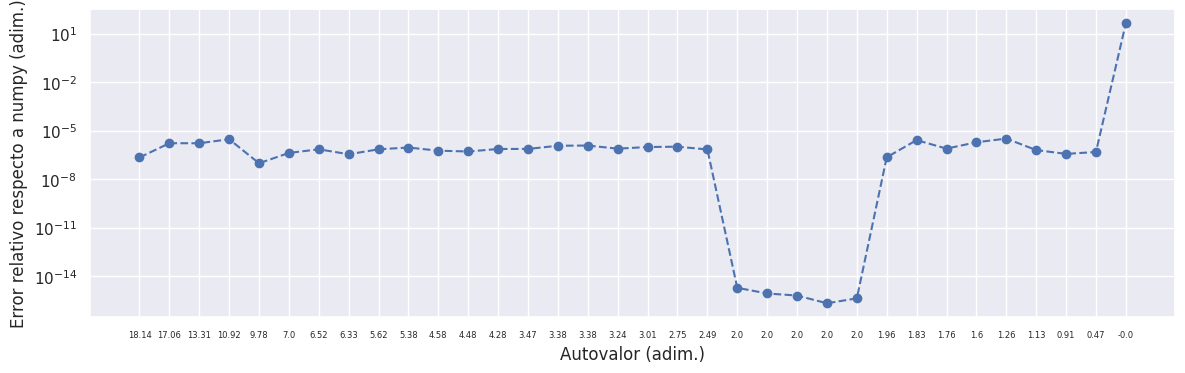

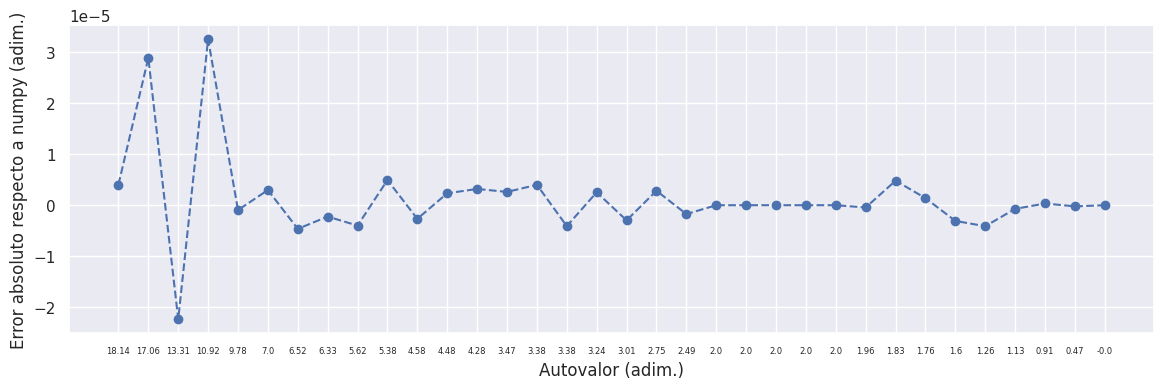

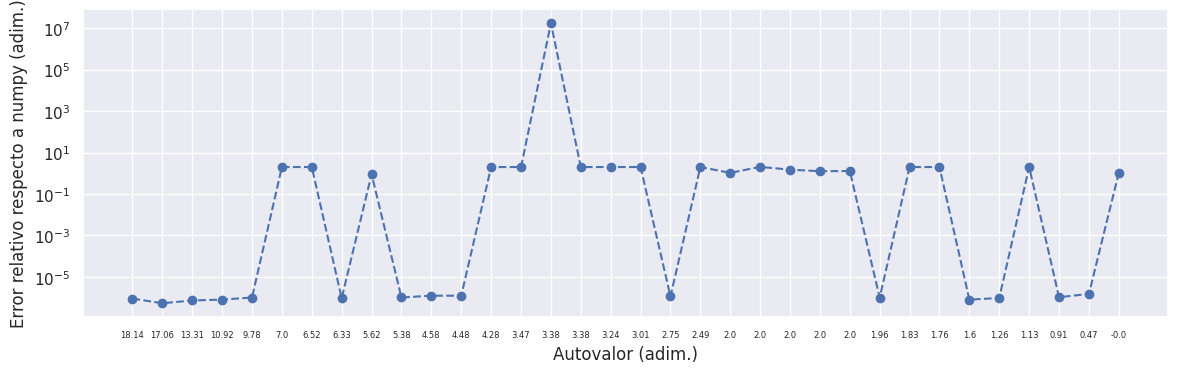

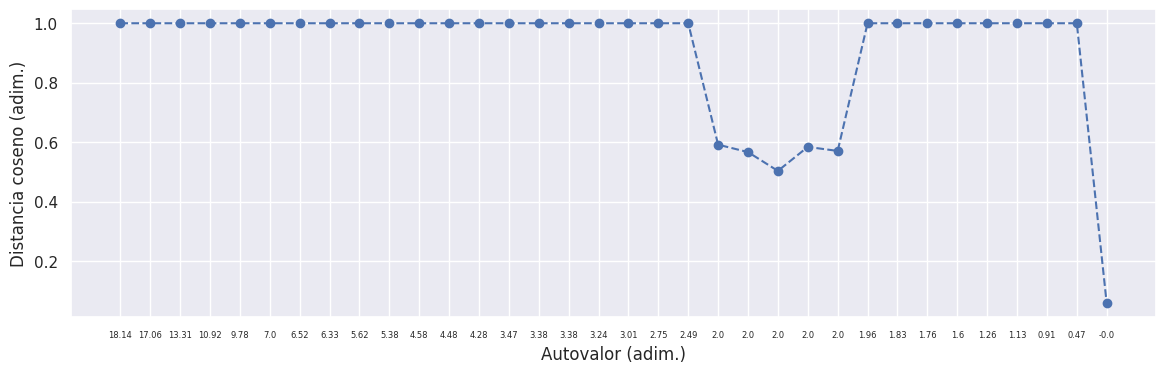

In [ ]:
A_karate = read_matrix_from_file("redes/karateclub_matriz.txt")
L_karate = laplacian_matrix(A_karate)
l_L_karate = np.load("nparrays/eval_karate_L.npy")
V_L_karate = normalize_V(np.load("nparrays/evec_karate_L.npy"))
l_L_karate_np, V_L_karate_np = sorted_eigen(*np.linalg.eig(L_karate))

# Autovalores
error_rel_l = np.abs(l_L_karate - l_L_karate_np)/l_L_karate_np
plt.figure(figsize = (14, 4))
plt.plot(error_rel_l, "o--")
plt.xticks(ticks = range(0, n_karate), labels = [round(l, 2) for l in l_L_karate], fontsize = 6)
plt.xlabel("Autovalor (adim.)")
plt.ylabel("Error relativo respecto a numpy (adim.)")
plt.yscale("log")
plt.show()

error_abs_l = l_L_karate - l_L_karate_np
plt.figure(figsize = (14, 4))
plt.plot(error_abs_l, "o--")
plt.xticks(ticks = range(0, n_karate), labels = [round(l, 2) for l in l_L_karate], fontsize = 6)
plt.xlabel("Autovalor (adim.)")
plt.ylabel("Error absoluto respecto a numpy (adim.)")
plt.show()

# Autovectores
error_rel_V = np.mean(np.abs((V_L_karate - V_L_karate_np)/V_L_karate_np), axis = 0)
plt.figure(figsize = (14, 4))
plt.plot(error_rel_V, "o--")
plt.xticks(ticks = range(0, n_karate), labels = [round(l, 2) for l in l_L_karate], fontsize = 6)
plt.xlabel("Autovalor (adim.)")
plt.ylabel("Error relativo respecto a numpy (adim.)")
plt.yscale("log")
plt.show()

# Autovectores (cos. dist.)
error_rel_V = [abs(V_L_karate[:,i].T@V_L_karate_np[:,i]) for i in range(n_karate)]
plt.figure(figsize = (14, 4))
plt.plot(error_rel_V, "o--")
plt.xticks(ticks = range(0, n_karate), labels = [round(l, 2) for l in l_L_karate], fontsize = 6)
plt.xlabel("Autovalor (adim.)")
plt.ylabel("Distancia coseno (adim.)")
plt.show()

# 3.1. Red de adyacencia a partir de umbral arbitrario de atributos en común

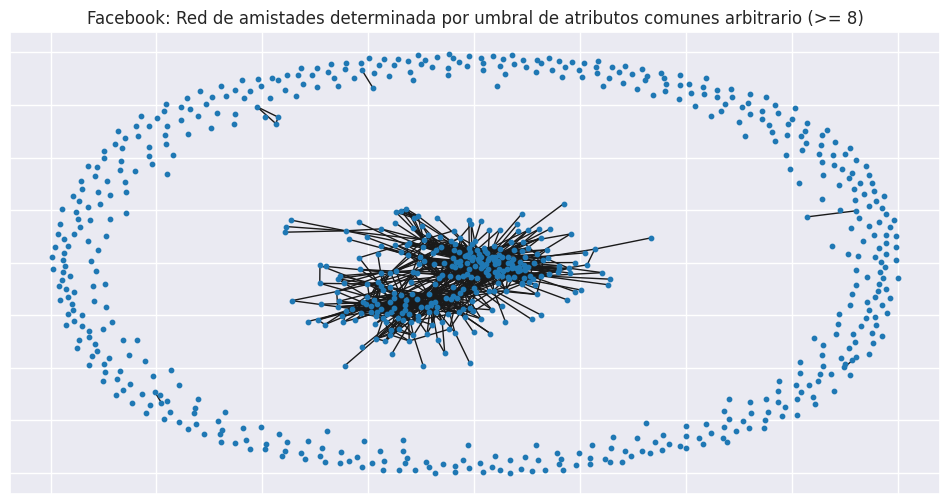

In [ ]:
A_facebook = read_matrix_from_file("redes/facebook_matriz.txt")
n_facebook = A_facebook.shape[0]
X = read_matrix_from_file("redes/ego-facebook-pre.feat")
C = X@X.T
u = 8 # umbral arbitrario de atributos en común
A_C_facebook = feature_threshold_adyacency_matrix(C, u)
G = nx.from_numpy_array(A_C_facebook)
pos = nx.spring_layout(G, k = 0.1)
plt.figure(figsize = (12, 6))
nx.draw_networkx(G, pos, with_labels = False, node_size = 10)
plt.title(f"Facebook: Red de amistades determinada por umbral de atributos comunes arbitrario (>= {u})")
plt.savefig("img/umbral_arbitrario_facebook.svg", bbox_inches = "tight")
plt.show()

# 3.2. Análisis de correlación para umbral arbitrario

In [ ]:
# Cómputo de autovalores y autovectores
umbrales = list(range(1,14)) # 14 inclusive en adelante da matriz de adyacencia nula
facebook_niter = 300
facebook_eps = 1e-5

if recompute:
    l_A_facebook, V_A_facebook = eig(A_facebook, n_facebook, niter = facebook_niter, eps = facebook_eps)
    np.save(f"nparrays/eval_facebook_A_{facebook_niter}_{facebook_eps}.npy", l_A_facebook)
    np.save(f"nparrays/evec_facebook_A_{facebook_niter}_{facebook_eps}.npy", V_A_facebook)
    for u in umbrales:
        A_C_facebook = feature_threshold_adyacency_matrix(C, u)
        l_A_C_facebook, V_A_C_facebook = eig(A_C_facebook, n_facebook, niter = facebook_niter, eps = facebook_eps)
        np.save(f"nparrays/eval_facebook_A_C_{u}_{facebook_niter}_{facebook_eps}.npy", l_A_C_facebook)
        np.save(f"nparrays/evec_facebook_A_C_{u}_{facebook_niter}_{facebook_eps}.npy", V_A_C_facebook)

In [ ]:
# 1. Correlación entre matrices aplanadas
abs_correlation = abs(pearsonr(A_facebook.flatten(), A_C_facebook.flatten())[0])
abs_correlation

0.06919137913198668

In [ ]:
# 2. Correlación entre lista de autovalores
l_A_facebook = np.load(f"nparrays/eval_facebook_A_{facebook_niter}_{facebook_eps}.npy")
l_A_C_facebook = np.load(f"nparrays/eval_facebook_A_C_{u}_{facebook_niter}_{facebook_eps}.npy")

l_A_facebook_np, _ = sorted_eigen(*np.linalg.eig(A_facebook))
l_A_C_facebook_np, _ = sorted_eigen(*np.linalg.eig(A_C_facebook))

correlation_l = pearsonr(l_A_facebook, l_A_C_facebook.real)[0]
correlation_l_np = pearsonr(l_A_facebook_np.real, l_A_C_facebook_np.real)[0]
print(correlation_l, correlation_l_np)

0.9354797044528554 0.9263822614169778


# 3.3. Múltiples umbrales

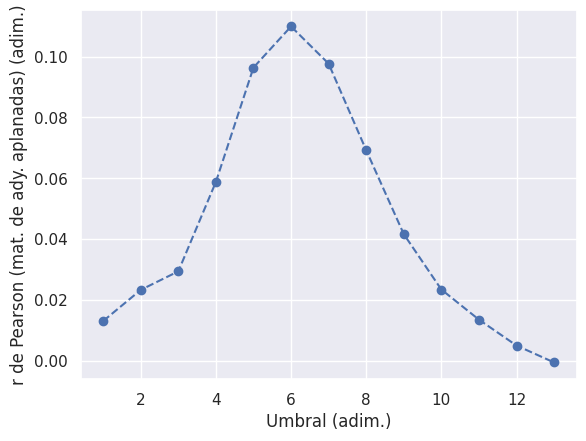

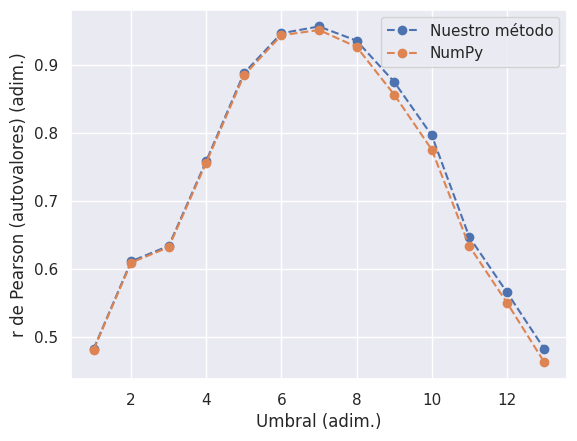

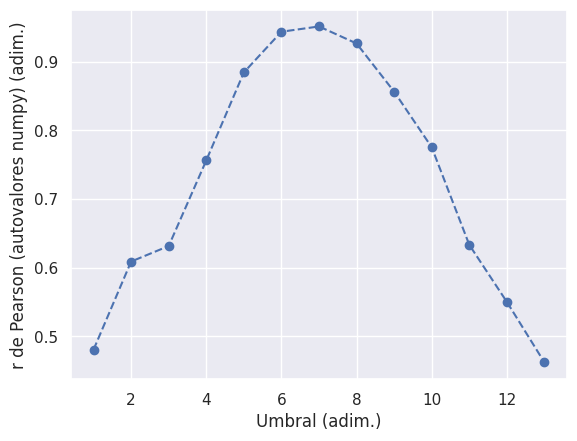

In [ ]:
correlaciones_flatten = []
correlaciones_autovals = []
correlaciones_autovals_np = [] # Validación con numpy
for u in umbrales:
    A_C_facebook = feature_threshold_adyacency_matrix(C, u)
    correlaciones_flatten.append(pearsonr(A_facebook.flatten(), A_C_facebook.flatten())[0])
    l_A_C_facebook = np.load(f"nparrays/eval_facebook_A_C_{u}_{facebook_niter}_{facebook_eps}.npy")
    correlaciones_autovals.append(pearsonr(l_A_facebook, l_A_C_facebook)[0])
    l_A_C_facebook_np, V_A_C_facebook_np = sorted_eigen(*np.linalg.eig(A_C_facebook))
    correlaciones_autovals_np.append(pearsonr(l_A_facebook_np.real, l_A_C_facebook_np.real)[0])
plt.plot(umbrales, correlaciones_flatten, "o--")
plt.ylabel("r de Pearson (mat. de ady. aplanadas) (adim.)")
plt.xlabel("Umbral (adim.)")
plt.savefig("img/correlacion_aplanado_facebook.svg", bbox_inches = "tight")
plt.show()
plt.plot(umbrales, correlaciones_autovals, "o--")
plt.plot(umbrales, correlaciones_autovals_np, "o--")
plt.ylabel("r de Pearson (autovalores) (adim.)")
plt.xlabel("Umbral (adim.)")
plt.legend(["Nuestro método", "NumPy"])
plt.savefig("img/correlacion_autovalores_facebook.svg", bbox_inches = "tight")
plt.show()
plt.plot(umbrales, correlaciones_autovals_np, "o--")
plt.ylabel("r de Pearson (autovalores numpy) (adim.)")
plt.xlabel("Umbral (adim.)")
plt.show()

In [ ]:
max_correlacion_flatten = max(correlaciones_flatten)
max_correlacion_autovals = max(correlaciones_autovals)
max_correlacion_flatten, max_correlacion_autovals

(0.10987884773141386, 0.9564032624164326)

# 3.4. PCA

In [ ]:
A_facebook = read_matrix_from_file("redes/facebook_matriz.txt")
n_facebook = A_facebook.shape[0]
X = read_matrix_from_file("redes/ego-facebook-pre.feat")
C = X@X.T
means = X.mean(0)
Xcentered = X - means

# calcular V completo con nuestro método
niter = 1_000
eps = 1e-10
CX = Xcentered.T@Xcentered/(X.shape[0] - 1)
if recompute:
    l, V = eig(CX, CX.shape[0], niter = niter, eps = eps)
    np.save(f"nparrays/eval_facebook_featuresCX_{niter}_{eps}.npy", l)
    np.save(f"nparrays/evec_facebook_featuresCX_{niter}_{eps}.npy", V)

l = np.load(f"nparrays/eval_facebook_featuresCX_{niter}_{eps}.npy")
V = np.load(f"nparrays/evec_facebook_featuresCX_{niter}_{eps}.npy")
l, V = sorted_eigen(l, V, absolute = True)

In [ ]:
# recompute = True
niter = 500
eps = 1e-5

correlaciones_flatten = []
correlaciones_autovals = []

umbrales = np.linspace(-1, 1, 20)
ks = [1,2,4,6,10,20,100,200,300,792]

for i, k in enumerate(ks):
    correlaciones_flatten.append([])
    correlaciones_autovals.append([])
    Xhat = Xcentered@V[:,:k] # proyectar Xcenteredd en las primeras k columnas de V
    norms = np.linalg.norm(Xhat, axis = 1, keepdims = True)
    C = Xhat@Xhat.T/(norms@norms.T)
    for u in umbrales:
        A_C_facebook = feature_threshold_adyacency_matrix(C, u)
        correlaciones_flatten[i].append(pearsonr(A_facebook.flatten(), A_C_facebook.flatten())[0])
        l_A_C_facebook_PCA_file = f"l_facebook_A_C_PCA_{niter}_{eps}_{k}_{u}.npy"
        if recompute and l_A_C_facebook_PCA_file not in os.listdir("nparrays"):
            l_A_C_facebook_PCA, _ = eig(A_C_facebook, A_C_facebook.shape[0], niter = niter, eps = eps)
            np.save("nparrays/" + l_A_C_facebook_PCA_file, l_A_C_facebook_PCA)
        l_A_C_facebook_PCA = np.load("nparrays/" + l_A_C_facebook_PCA_file)
        correlaciones_autovals[i].append(pearsonr(l_A_facebook, l_A_C_facebook_PCA)[0])

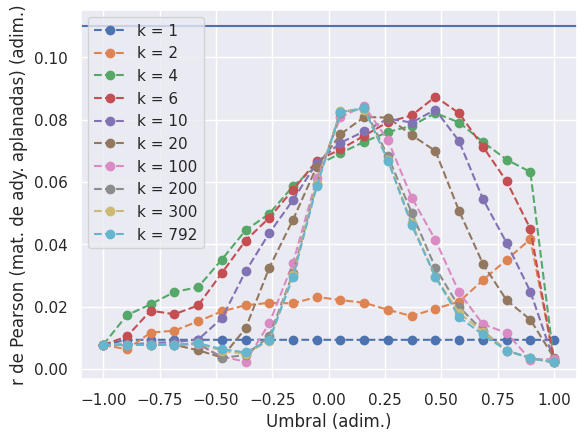

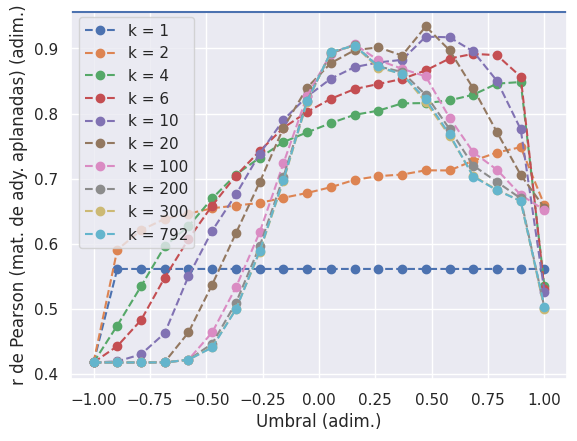

In [ ]:
for correlaciones in correlaciones_flatten:
    plt.plot(umbrales, correlaciones, "--o")
plt.axhline(max_correlacion_flatten)
plt.legend(["k = "+str(k) for k in ks])
plt.ylabel("r de Pearson (mat. de ady. aplanadas) (adim.)")
plt.xlabel("Umbral (adim.)")
plt.savefig("img/correlacion_aplanado_PCA_facebook.svg", bbox_inches = "tight")
plt.show()

for correlaciones in correlaciones_autovals:
    plt.plot(umbrales, correlaciones, "--o")
plt.axhline(max_correlacion_autovals)
plt.legend(["k = "+str(k) for k in ks])
plt.ylabel("r de Pearson (mat. de ady. aplanadas) (adim.)")
plt.xlabel("Umbral (adim.)")
plt.savefig("img/correlacion_autovalores_PCA_facebook.svg", bbox_inches = "tight")
plt.show()